In [1]:
import os
import warnings
from parmed.exceptions import GromacsWarning
warnings.simplefilter("ignore", GromacsWarning)
warnings.simplefilter("ignore", UserWarning)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import mbuild as mb
import metamds as mds
import mdtraj

import nglview
from ipywidgets.widgets import Box

%matplotlib inline
!rm -rf output/ *.top *.gro

In [2]:
def build_monolayer(chain_length, n_molecules, **kwargs):
    from mbuild.examples import AlkaneMonolayer
    pattern = mb.Random2DPattern(n_molecules)
    monolayer = AlkaneMonolayer(pattern, tile_x=1, tile_y=1, 
                                chain_length=chain_length)
    mb.translate(monolayer, [0, 0, 2])
    return monolayer

In [3]:
def create_run_script(build_func, forcefield, input_dir, **kwargs):
    compound = build_func(**kwargs)
    name = compound.name
    em = os.path.join(input_dir, 'em.mdp')
    nvt = os.path.join(input_dir, 'nvt.mdp')
    gro = '{name}.gro'.format(name=name)
    top = '{name}.top'.format(name=name)

    box = compound.boundingbox
    compound.periodicity += np.array([0, 0, 5 * box.lengths[2]])
    compound.save(top, forcefield=forcefield, overwrite=True)

    em_grompp = 'gmx grompp -f {mdp} -c {gro} -p {top} -o em.tpr'.format(mdp=em, gro=gro, top=top)
    em_mdrun = 'gmx mdrun -v -deffnm em -ntmpi 1'

    nvt_grompp = 'gmx grompp -f {mdp} -c em.gro -p {top} -o nvt.tpr'.format(mdp=nvt, top=top)
    nvt_mdrun = 'gmx mdrun -v -deffnm nvt -ntmpi 1'

    script = (em_grompp, em_mdrun, nvt_grompp, nvt_mdrun)
    return script

In [4]:
# Initialize simulation with a template and some metadata
sim = mds.Simulation(name='monolayer', 
                     template=create_run_script, 
                     output_dir='output')

chain_lengths = [8, 12, 16, 20]
for length in chain_lengths:
    parameters = {'chain_length': length,
                  'n_molecules': 100,
                  'forcefield': 'OPLS-aa',
                  'build_func': build_monolayer}
    # Parameterize our simulation template
    sim.parametrize(**parameters)

In [5]:
# Run
sim.execute_all(hostname='rahman.vuse.vanderbilt.edu', username='ctk3b')

DEBUG:monolayer_debug:rsync -r -h --progress --partial /Users/ctk3b/science/python/imodels/demos/demos/monolayer/em.mdp /Users/ctk3b/science/python/imodels/demos/demos/monolayer/nvt.mdp /Users/ctk3b/science/python/imodels/demos/demos/monolayer/oplsaa.ff ctk3b@rahman.vuse.vanderbilt.edu:/raid6/homes/ctk3b/tmp.HqJQMZZEZA
DEBUG:monolayer_debug:b'building file list ... '
DEBUG:monolayer_debug:b' 0 files...'
DEBUG:monolayer_debug:b'29 files to consider'
DEBUG:monolayer_debug:b'em.mdp'
DEBUG:monolayer_debug:b'         853 100%    0.00kB/s    0:00:00'
DEBUG:monolayer_debug:b'         853 100%    0.00kB/s    0:00:00 (xfer#1, to-check=28/29)'
DEBUG:monolayer_debug:b'nvt.mdp'
DEBUG:monolayer_debug:b'         534 100%  521.48kB/s    0:00:00'
DEBUG:monolayer_debug:b'         534 100%  521.48kB/s    0:00:00 (xfer#2, to-check=27/29)'
DEBUG:monolayer_debug:b'oplsaa.ff/'
DEBUG:monolayer_debug:b'oplsaa.ff/.aminoacids.rtp.swp'
DEBUG:monolayer_debug:b'      32.77K  53%   31.25MB/s    0:00:00'
DEBUG:monol

In [11]:
sim.sync_all()

DEBUG:monolayer_debug:rsync -r -h --progress --partial ctk3b@rahman.vuse.vanderbilt.edu:/raid6/homes/ctk3b/tmp.HqJQMZZEZA/output/task_0/* /Users/ctk3b/science/python/imodels/demos/demos/monolayer/output/task_0
DEBUG:monolayer_debug:b'receiving file list ... '
DEBUG:monolayer_debug:b'19 files to consider'
DEBUG:monolayer_debug:b'#mdout.mdp.1#'
DEBUG:monolayer_debug:b'           0   0%    0.00kB/s    0:00:00'
DEBUG:monolayer_debug:b'      11.63K 100%   11.09MB/s    0:00:00 (xfer#1, to-check=18/19)'
DEBUG:monolayer_debug:b'AlkaneMonolayer.gro'
DEBUG:monolayer_debug:b'           0   0%    0.00kB/s    0:00:00'
DEBUG:monolayer_debug:b'     216.08K 100%   41.21MB/s    0:00:00 (xfer#2, to-check=17/19)'
DEBUG:monolayer_debug:b'skipping non-regular file "em.mdp"'
DEBUG:monolayer_debug:b'skipping non-regular file "nvt.mdp"'
DEBUG:monolayer_debug:b'AlkaneMonolayer.top'
DEBUG:monolayer_debug:b'           0   0%    0.00kB/s    0:00:00'
DEBUG:monolayer_debug:b'skipping non-regular file "oplsaa.ff"'
D

In [12]:
task_1 = next(sim.tasks())
trj_path = os.path.join(task_1.output_dir, 'nvt.xtc')
top_path = os.path.join(task_1.output_dir, 'em.gro')
traj = md.load(trj_path, top=top_path)
print(traj)

<mdtraj.Trajectory with 201 frames, 4800 atoms, 1 residues, and unitcells>


In [13]:
t = nglview.MDTrajTrajectory(traj)
w = nglview.NGLWidget(t)
w.representations = [{'type':'ball+stick'}]
Box(children=(w,))

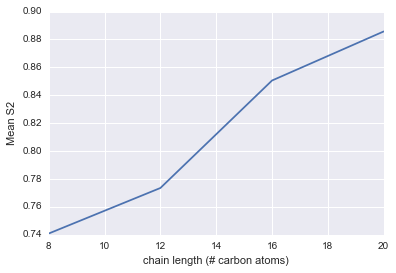

In [10]:
average_S2 = list()
for task in sim.tasks():
    # Load up the trajectory
    trj_path = os.path.join(task.output_dir, 'nvt.xtc')
    top_path = os.path.join(task.output_dir, 'em.gro')
    traj = md.load(trj_path, top=top_path)
    
    # Nematic order parameter
    atoms_per_chain = int((traj.n_atoms - 1800) / 100)
    chain_indices = [[n+x for x in range(atoms_per_chain)] 
                     for n in range(1800, traj.n_atoms, atoms_per_chain)]
    s2 = md.compute_nematic_order(traj, indices=chain_indices)
    average_S2.append(np.mean(s2))
    
    
plt.plot(chain_lengths, average_S2)
plt.xlabel('chain length (# carbon atoms)')
plt.ylabel('Mean S2')